In [67]:
import os
from os.path import join
import numpy as np
import cv2
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import random as rng
from itertools import combinations
from scipy.ndimage import interpolation


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
filenames = os.listdir('images2')
filenames.sort()

In [425]:
def closest_point_idx(point, dst_points):
    x, y = point
    distances = [(x-p[0])**2 + (y-p[1])**2 for p in dst_points]
    
    return np.argmin(distances)

class Puzzle:
    
    @property
    def contours(self):
        thresh_blurred = self.thresh_blurred
        contours, hierarchy = cv2.findContours(thresh_blurred, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[-2:]
        return contours
    
    @property
    def contours_drawing(self):
        thresh_blurred = self.thresh_blurred
        contour_drawing = np.zeros((thresh_blurred.shape[0], thresh_blurred.shape[1]), dtype=np.uint8)
        
        contours = self.contours
        for i in range(len(contours)):
            contour_color = (255,255,255)        
            cv2.drawContours(contour_drawing, contours, i, 255)
        
        return contour_drawing
    
    @property
    def puzzle_contour(self):
        """ Returns contour which is child of the root and has the biggest number of 
            points.
        """
        thresh_blurred = self.thresh_blurred
        contours, hierarchy = cv2.findContours(thresh_blurred, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[-2:]
        
        contours = [c for c, h in zip(contours, hierarchy[0]) if h[3] == 0]
        
        puzzle_contour = contours[np.argmax([c.shape[0] for c in contours])]
        
        return puzzle_contour
    
    @property
    def hull_defects(self):
        contours = self.contours
        puzzle_contour = self.puzzle_contour
        hull = cv2.convexHull(puzzle_contour, returnPoints = False)
        defects = cv2.convexityDefects(puzzle_contour, hull)
        
        return defects
    
    @property
    def corners(self):
        thresh_blurred = self.thresh_blurred
        corners = cv2.goodFeaturesToTrack(thresh_blurred, 25, 0.01, 20, 
                                  blockSize=3, 
                                  useHarrisDetector=True, 
                                  k=0.035)
        corners = np.int0(corners).squeeze()
        
        return corners
    
    @property
    def best_corners(self):
        corners = self.corners
        corner_combinations = list(combinations(corners.squeeze(), 4))
        areas = [cv2.contourArea(cv2.convexHull(np.array(c))) for c in corner_combinations]

        best_corners = corner_combinations[np.argmax(areas)]
        
        return best_corners
    
    @property
    def edges(self):
        if self._edges:
            return self._edges
        
        best_corners = self.best_corners
        contours = self.contours
        puzzle_contour = self.puzzle_contour
        
        puzzle_corners = list(map(tuple, best_corners))
        contour_tuples = list(map(tuple, puzzle_contour.squeeze()))

        split_indices = [closest_point_idx(puzzle_corners[i], contour_tuples) for i in range(4)]

        edges = np.split(contour_tuples, sorted(split_indices))
        if len(edges) == 5:
            edges[0] = np.vstack([edges[4], edges[0]])
            edges = edges[:-1]
            
        edge_tuples = [list(map(tuple, edges[i])) for i in range(4)]
        defects = self.hull_defects
        edge_defects = [set() for _ in range(4)]
        
        for i in range(defects.shape[0]):
            s,e,f,d = defects[i,0]

            start = tuple(puzzle_contour[s][0])
            end = tuple(puzzle_contour[e][0])
            far = tuple(puzzle_contour[f][0])
            if d > 1000:
                for edge_idx in range(4):
                    if far in edge_tuples[edge_idx]:
                        edge_defects[edge_idx].add(far)
            
        self._edges = [Edge(self, e, d) for e, d in zip(edges, edge_defects)]
        
        return self._edges
    
    @property
    def is_corner(self):
        return sum(1 if e.edge_type == 'straight' else 0 for e in self.edges) == 2
        
    @property
    def puzzle_image_no_bg(self):
        puzzle_image = self.puzzle_image.copy()
        
        puzzle_image[self.thresh_blurred > 250] = 0
        
        return puzzle_image
    
    def __init__(self, puzzle_image):
        self.puzzle_image = puzzle_image#cv2.cvtColor(puzzle_image, cv2.COLOR_BGR2RGB) 
        
        gray = cv2.cvtColor(self.puzzle_image, cv2.COLOR_RGB2GRAY)
        gray_blurred = cv2.medianBlur(gray, ksize=1)
        thresh = cv2.threshold(gray_blurred, 230, 255, cv2.THRESH_BINARY)[1]
        thresh_blurred = cv2.blur(thresh, ksize=(3, 3))
        
        self.gray = gray
        self.thresh_blurred = thresh_blurred
        
        """ Mask threshold image with puzzle contour with some buffer"""
        mask = np.zeros(thresh_blurred.shape, np.uint8)
        puzzle_contour = self.puzzle_contour
        cv2.fillPoly(mask, pts =[puzzle_contour], color=(255))
        cv2.drawContours(mask, [puzzle_contour], 0, 255, 5)
        
        self.thresh_blurred[mask==0] = 255
        
        self._edges = []
        
    def draw_puzzle(self):
        puzzle_img = self.puzzle_image
        plt.figure(figsize=(10, 10))
        plt.imshow(puzzle_img, cmap='gray')
        plt.show()
        
    def draw_puzzle_analysis(self):
        thresh_blurred = self.thresh_blurred
        contours = self.contours
        puzzle_contour = self.puzzle_contour
        defects = self.hull_defects
        corners = self.corners
        best_corners = self.best_corners
        edges = self.edges
        
        drawing = np.zeros((thresh_blurred.shape[0], thresh_blurred.shape[1], 3), dtype=np.uint8)

        for i in range(len(contours)):
            contour_color = (255,255,255)        
            cv2.drawContours(drawing, contours, i, contour_color)
        
        for i in range(defects.shape[0]):
            s,e,f,d = defects[i,0]

            start = tuple(puzzle_contour[s][0])
            end = tuple(puzzle_contour[e][0])
            far = tuple(puzzle_contour[f][0])
            if d > 1000:
                cv2.circle(drawing,far,2,[255,0,255],2)
            
        for i in corners:
            x,y = i.ravel()
            cv2.circle(drawing,(x,y),2,(0, 255, 255),-1)
            
        for i in best_corners:
            x,y = i.ravel()
            cv2.circle(drawing,(x,y),3,(0, 255, 0),-1)
            
        edge_colors = [(255, 0, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255)]
        edge_by_type = {'straight':(255, 0, 0), 'header':(0, 0, 255), 'hole':(255, 0, 255)}
        for idx, edge in enumerate(edges):
            cv2.polylines(drawing, 
                          [np.array(edge.points)], 
                          isClosed = False,
                          color = edge_by_type[edge.edge_type], #edge_colors[idx],
                          thickness = 1)
            
        plt.figure(figsize=(10, 10))
        plt.imshow(drawing, cmap='gray')
        plt.show()
        
        
class Edge:
    @property
    def edge_type(self):
        if len(self.defects) == 1:
            return 'hole'
        elif len(self.defects) == 2:
            return 'header'
        else:
            return 'straight'
    
    @property
    def next_edge(self):
        own_puzzle_edges = self.puzzle.edges
        self_index = own_puzzle_edges.index(self)
        
        return self.puzzle.edges[(self_index + 1) % 4]
        
        
    @property
    def prev_edge(self):
        own_puzzle_edges = self.puzzle.edges
        self_index = own_puzzle_edges.index(self)
        
        return self.puzzle.edges[(self_index - 1) % 4]
    
    
    @property
    def length(self):
        return np.linalg.norm(self.points[0] - self.points[-1])
        
    def __init__(self, puzzle, edge_points, edge_defects):
        self.puzzle = puzzle
        self.points = edge_points
        self.defects = edge_defects
    
    def get_color_array(self, thickness):
        puzzle_image = self.puzzle.puzzle_image.copy()
        edge_mask = np.zeros((puzzle_image.shape[0], puzzle_image.shape[1], 3), dtype=np.uint8)
        
        cv2.polylines(edge_mask, 
          [np.array(self.points)], 
          isClosed = False,
          color = (255,255,255),
          thickness = thickness)
        
        puzzle_image[edge_mask != 255] = 0
        puzzle_image[puzzle_image >= 250] = 0
        
        return puzzle_image
    
    def draw_edge(self, width=3):
        edge_array = self.get_color_array(width)
    
        plt.figure(figsize=(10, 10))
        plt.title('edge')
        plt.imshow(edge_array)
        plt.show()
        
    def can_be_connected_with(self, other_edge):
        if self.puzzle == other_edge.puzzle:
            return False
        
        if 'straight' in [self.edge_type, other_edge.edge_type]:
            return False
        
        if self.edge_type == other_edge.edge_type:
            return False
        
        own_puzzle_edges = self.puzzle.edges
        other_puzzle_edges = other_edge.puzzle.edges
            
        self_index = own_puzzle_edges.index(self)
        self_left_neighbour = own_puzzle_edges[self_index-1]
        self_right_neighbour = own_puzzle_edges[(self_index+1) % 4] 

        other_index = other_puzzle_edges.index(other_edge)
        other_left_neighbour = other_puzzle_edges[other_index-1]
        other_right_neighbour = other_puzzle_edges[(other_index+1) % 4] 
        
        
        if sum(1 if e.edge_type == 'straight' else 0 for e in [self_left_neighbour, other_right_neighbour]) == 1:
            return False
        
        if sum(1 if e.edge_type == 'straight' else 0 for e in [self_right_neighbour, other_left_neighbour]) == 1:
            return False
    
        return True

        
    def color_distance(self, other_edge):
        
        self_edge_mat = (self.get_color_array(3) > 0).any(axis=2) 
        other_edge_mat = (other_edge.get_color_array(3) > 0).any(axis=2) 
        
        self_mean_color = self.get_color_array(3)[self_edge_mat].mean(axis=0)
        other_mean_color = other_edge.get_color_array(3)[other_edge_mat].mean(axis=0)
        
        return ((self_mean_color - other_mean_color) ** 2).sum()
        
    def shape_distance(self, other_edge):
        return cv2.matchShapes(self.points, other_edge.points, 2, 0.0)
        
    def color_segment_distance(self, other_edge, plot=False):
        e1 = self
        e2 = other_edge

        src = e1.get_color_array(1)
        dst = e2.get_color_array(1)
        
        len_e1_points = len(e1.points)
        len_e2_points = len(e2.points)
        
        e1_pixels_seq = []
        e2_pixels_seq = []
        diff_seq = []
        
        e1_points = e1.points
        e2_points = e2.points[::-1]
        
        diff_sum = 0.0
        for i in range(len_e1_points):
            e2_i = int((len_e2_points * i) / len_e1_points)
            e1_point = e1_points[i].astype(int)
            e2_point = e2_points[e2_i].astype(int)

            e1_pixels = src[e1_point[1]-1:e1_point[1]+2, e1_point[0]-1:e1_point[0]+2]
            e2_pixels = dst[e2_point[1]-1:e2_point[1]+2, e2_point[0]-1:e2_point[0]+2]
            
            e1_pixels = e1_pixels.reshape(9, -1)
            e1_pixels = e1_pixels[e1_pixels.sum(axis=1) > 0].mean(axis=0)
            
            e2_pixels = e2_pixels.reshape(9, -1)
            e2_pixels = e2_pixels[e2_pixels.sum(axis=1) > 0].mean(axis=0)
            
            e1_pixels_seq.append(e1_pixels)
            e2_pixels_seq.append(e2_pixels)
        
        e1_pixels_seq = cv2.blur(np.array(e1_pixels_seq)[None, :, :], (30, 30))
        e2_pixels_seq = cv2.blur(np.array(e2_pixels_seq)[None, :, :], (30, 30))

        for e1_pixels, e2_pixels in zip(e1_pixels_seq[0], e2_pixels_seq[0]):
            e1_pixels = e1_pixels / 255
            e2_pixels = e2_pixels / 255
            diff = np.sqrt(((e1_pixels - e2_pixels) ** 2).sum())
            diff_sum += diff
            diff_seq.append(diff)
        
        diff_sum = diff_sum / len_e1_points
            
        if plot:
            plt.figure(figsize=(10, 10))
            plt.title('src')
            plt.imshow(src, cmap='gray')
            plt.show()

            plt.figure(figsize=(10, 10))
            plt.title('dst')
            plt.imshow(dst, cmap='gray')
            plt.show()

            e1_pixels_seq = np.array(e1_pixels_seq).reshape(1, -1, 3).astype(int)
            plt.figure(figsize=(20, 20))
            plt.imshow(e1_pixels_seq)
            plt.show()
            
            e2_pixels_seq = np.array(e2_pixels_seq).reshape(1, -1, 3).astype(int)
            plt.figure(figsize=(20, 20))
            plt.imshow(e2_pixels_seq)
            plt.show()
            
            print(np.concatenate([e1_pixels_seq, e2_pixels_seq, np.array(diff_seq)[None, :, None]], axis=2))
            
            plt.figure(figsize=(20, 20))
            plt.imshow(np.array(diff_seq)[None, :], cmap='gray')
            plt.show()
        
        return diff_sum
    
    def affine_distance(self, other_edge, plot=False):
        
        e1_p_first, e1_p_last = self.points[0], self.points[-1]
        e2_p_first, e2_p_last = other_edge.points[0], other_edge.points[-1]

        v1 = np.array(e1_p_first) - np.array(e1_p_last)
        v2 = e2_p_last - e2_p_first

        dot = v1[0] * v2[0] + v1[1] * v2[1]      # dot product between [x1, y1] and [x2, y2]
        det = v1[0] * v2[1] - v1[1] * v2[0]
        alpha = np.arctan2(det, dot)
        
        rotation_point = tuple(e2_p_first + v2/2.0)
        warp_mat = cv2.getRotationMatrix2D(rotation_point, 180*alpha/np.pi, 1)
        bias = e1_p_last + v1/2.0 - rotation_point
        warp_mat[:, 2] = warp_mat[:, 2] + bias
            
        aligned_e2_points = other_edge.points.dot(warp_mat[:, :2].T) + warp_mat[:, 2]
        
        zoom = self.points.shape[0] / aligned_e2_points.shape[0]
        aligned_e2_points_interp_0 = interpolation.zoom(aligned_e2_points[:, 0], zoom, mode='nearest')[:, None]
        aligned_e2_points_interp_1 = interpolation.zoom(aligned_e2_points[:, 1], zoom, mode='nearest')[:, None] 
        aligned_e2_points = np.hstack([aligned_e2_points_interp_0,aligned_e2_points_interp_1]).reshape(-1, 2)
        
        if plot:
            print('original_points', self.points[::-1])
            print('aligned points', aligned_e2_points)
            print('mean error = ', np.sqrt(((self.points[::-1] - aligned_e2_points) ** 2).sum()))
            img1 = np.zeros((300, 300, 3))

            for x,y in self.points:
                img1[int(y),int(x), :] = 255
            plt.imshow(img1)

            for x,y in aligned_e2_points:
                img1[int(y),int(x), :] = 255
            plt.imshow(img1)
            
        return np.sqrt(((self.points[::-1] - aligned_e2_points) ** 2).sum()) / self.points.shape[0] 

## Real puzzles

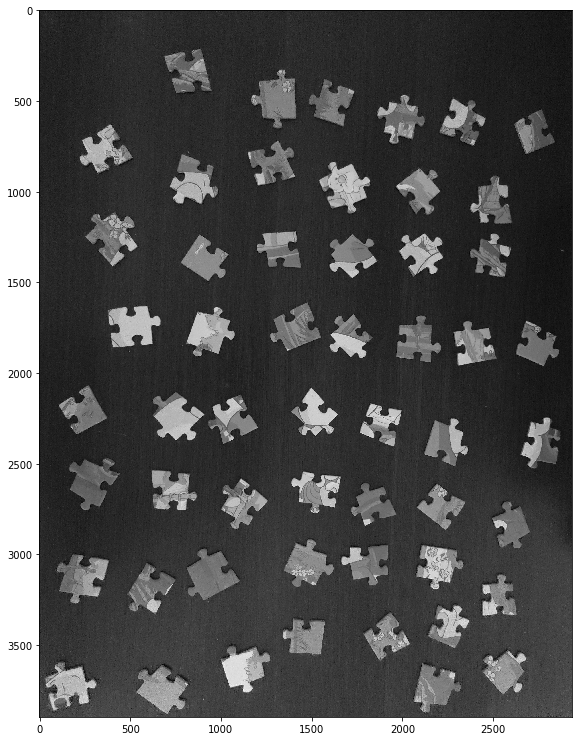

[0 3 2 1]


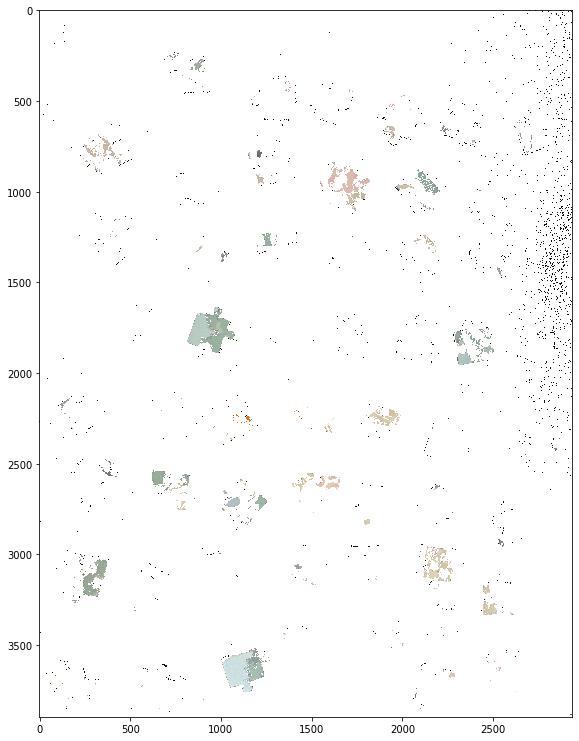

In [452]:
#img = cv2.imread('C:/pwr/AIOW/PuzzleSolver/puchatek.jpg')
img = cv2.imread('./puzzle3.jpg')

plt.figure(figsize=(13, 13))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cmap='gray')
plt.show()

img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#mg = img[1000:2000, :1000]



z = np.float32(img).reshape(-1, 3)[:, 1:]
#z = np.float32(img).reshape(-1, 3)[:, :2]
z = (z - z.min(axis=0)) / z.max(axis=0)


criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 1.0)
flags = cv2.KMEANS_RANDOM_CENTERS
compactness, labels, centers = cv2.kmeans(z, 4, None, criteria, 1, flags)

biggest_classes = np.argsort(np.bincount(labels.flatten()))[::-1]

print(biggest_classes)

img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
img_shape = img.shape

img_no_bg = img.copy().reshape(-1, 3)
for i in range(1):
    background_classes = (labels == biggest_classes[i])
    img_no_bg[background_classes.flatten(), :] = 255 


img_no_bg = img_no_bg.reshape(img_shape)

plt.figure(figsize=(13, 13))
plt.imshow(img_no_bg)
plt.show()


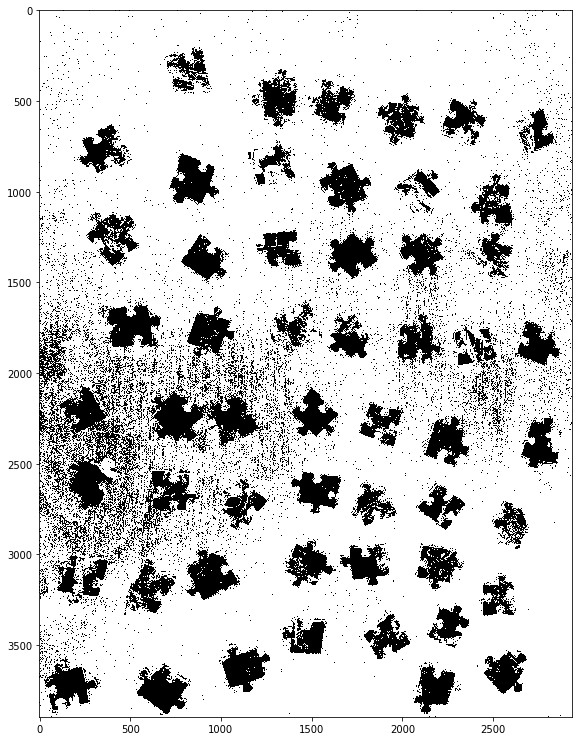

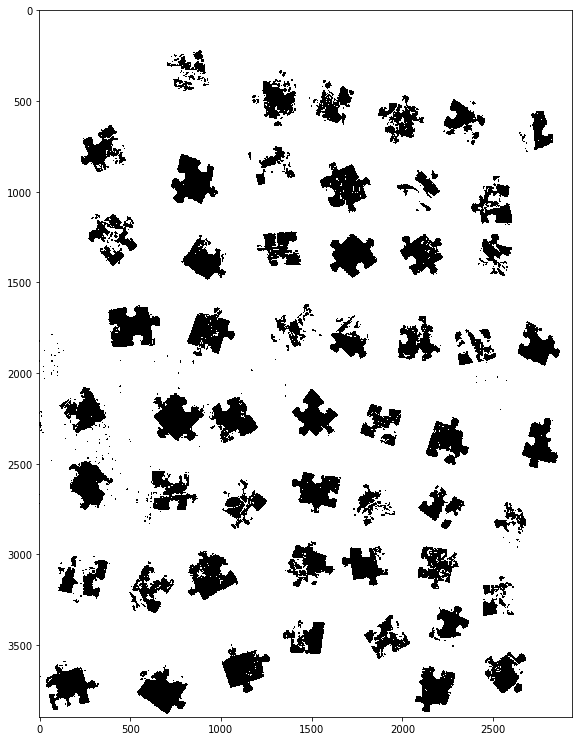

In [441]:
img_no_bg[np.any(img_no_bg < 255, axis=2)] = 0

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(6,6))

open_img = cv2.morphologyEx(img_no_bg, cv2.MORPH_CLOSE, kernel, iterations=1)
close_img = cv2.morphologyEx(open_img, cv2.MORPH_CLOSE, kernel)
tophat_img = cv2.morphologyEx(img_no_bg, cv2.MORPH_TOPHAT, kernel) 

#open_img = cv2.morphologyEx(open_img, cv2.MORPH_OPEN, (6,6))
plt.figure(figsize=(13, 13))
plt.imshow(img_no_bg)
plt.show()

plt.figure(figsize=(13, 13))
plt.imshow(open_img)
plt.show()


In [118]:
img_copy = img.copy()

In [119]:
img_copy[np.any(open_img != 0,axis=2)] = 255

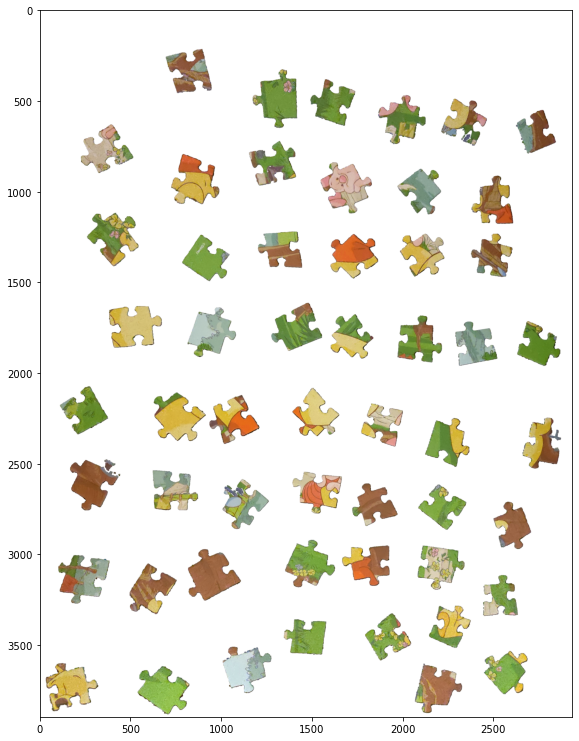

In [120]:
plt.figure(figsize=(13, 13))
plt.imshow(img_copy)
plt.show()

## Extract puzzles

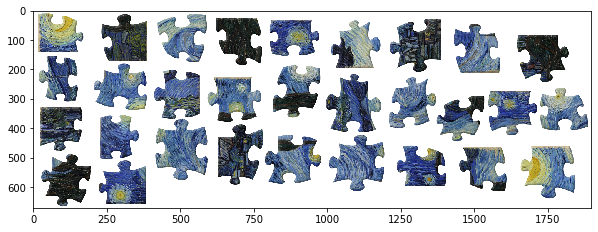

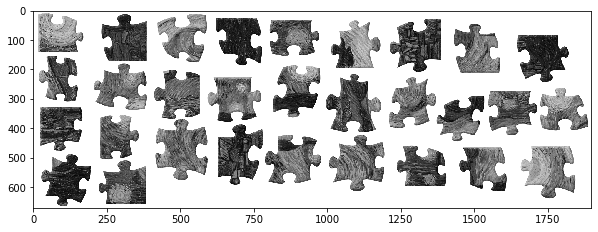

1


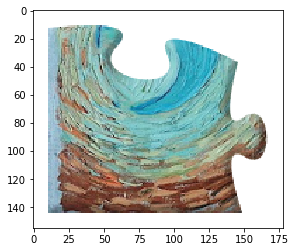

2


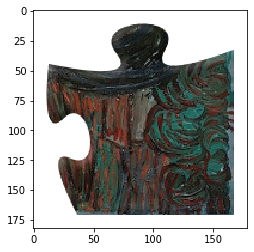

3


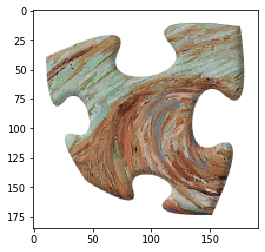

4


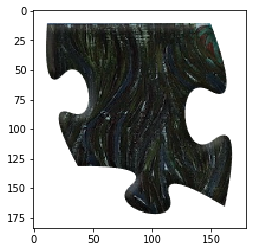

5


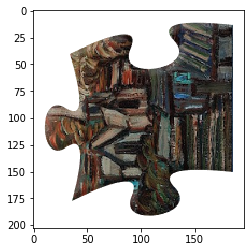

6


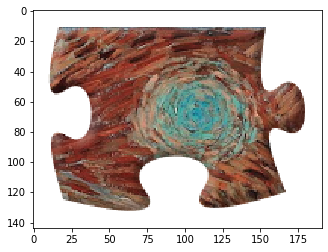

7


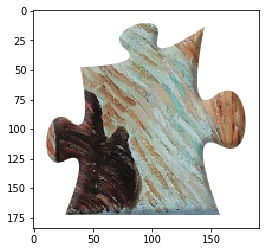

8


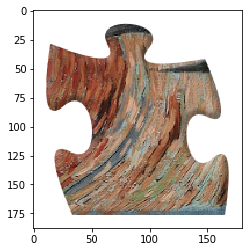

9


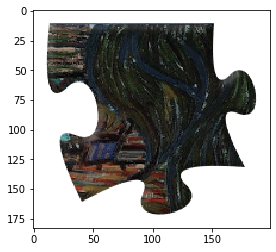

10


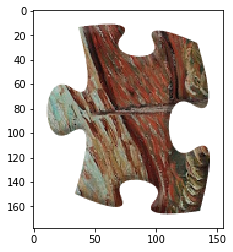

11


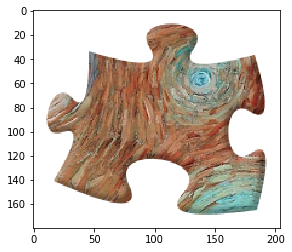

12


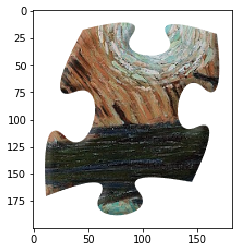

13


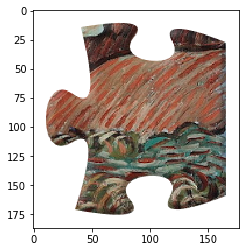

14


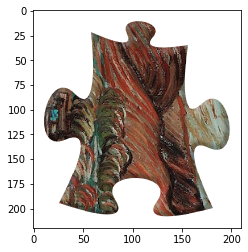

15


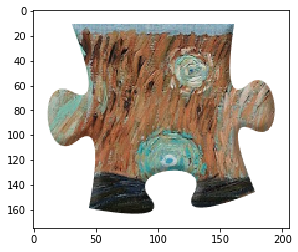

16


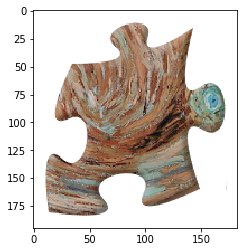

17


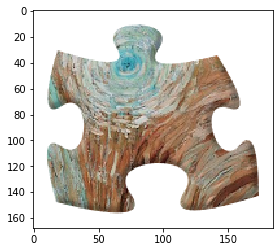

18


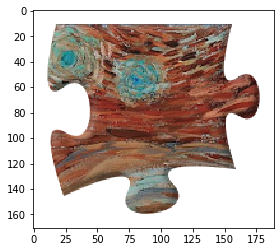

19


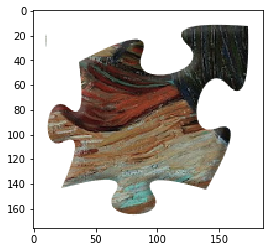

20


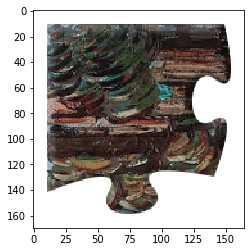

21


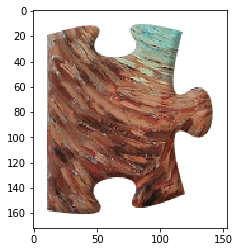

22


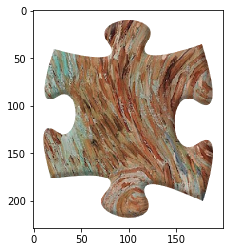

23


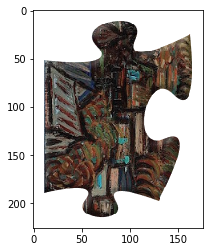

24


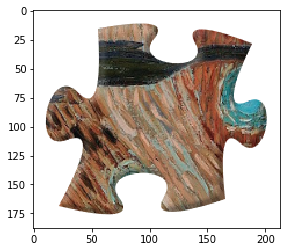

25


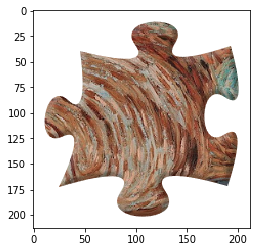

26


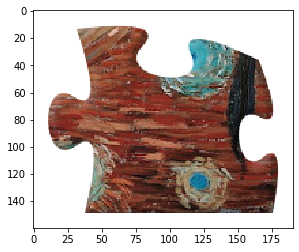

27


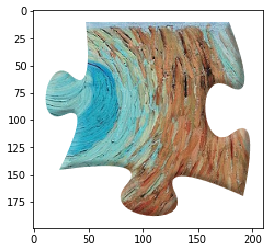

28


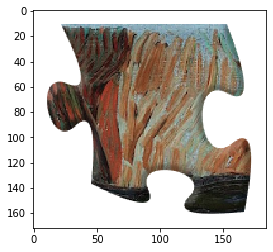

29


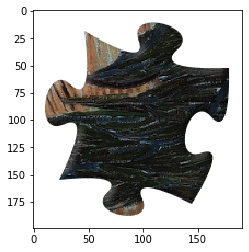

30


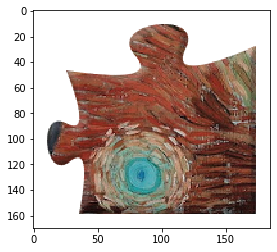

In [426]:
def get_segment_crop(img, mask, buffer=10):
    cropped = img[np.ix_(mask.any(1), mask.any(0))]
    
    size_x, size_y, channels = cropped.shape
    
    new_cropped = np.ones((size_x + 2 * buffer, size_y + 2 * buffer, channels), dtype=np.uint8) * 255
    new_cropped[buffer:size_x+buffer, buffer:size_y+buffer] = cropped
    
    return new_cropped

img = cv2.imread('./images/van-gogh.png')
#img = cv2.imread('C:/pwr/AIOW/PuzzleSolver/puchatek.jpg')
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img = cv2.imread('C:/pwr/AIOW/PuzzleSolver/dog_puzzle.png')
#img = img_copy
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


gray_blurred = cv2.medianBlur(gray, ksize=1)
thresh = cv2.threshold(gray_blurred, 230, 255, cv2.THRESH_BINARY)[1]
thresh_blurred = cv2.blur(thresh, ksize=(3, 3))
thresh_blurred = cv2.bitwise_not(thresh_blurred)

plt.figure(figsize=(10, 10))
plt.imshow(gray, cmap='gray')
plt.show()

drawing = np.zeros((thresh_blurred.shape[0], thresh_blurred.shape[1], 3), dtype=np.uint8)

result = cv2.connectedComponents(thresh_blurred, drawing)
puzzle_num = result[0]

puzzles = []
for puzzle_idx in range(1, puzzle_num+1):
    
    puzzle_img = get_segment_crop(img, result[1] == puzzle_idx)
    
    if puzzle_img.shape[0] < 100 or puzzle_img.shape[1] < 100:
        continue
    
    puzzles.append(Puzzle(puzzle_img))
    
    print(puzzle_idx)
    #plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(puzzle_img, cv2.COLOR_BGR2RGB) )
    plt.show()
    #puzzle = Puzzle(puzzle_img)
    #puzzle.draw_puzzle_analysis()


## Compute edge similarity

In [427]:
#edges = [e for p in puzzles for e in p.edges if e.edge_type != 'straight']
edges = [e for p in puzzles for e in p.edges]

In [434]:
edge_num = len(edges)
print(f'edge_num = {edge_num}')
edge_distance_dict = {}

for idx_e1, e1 in enumerate(edges):
    for idx_e2, e2 in enumerate(edges):
        
        edge_distance_dict[e1, e2] = 99999
        
        if not e1.can_be_connected_with(e2):
            continue
        distance = e1.affine_distance(e2, plot=False) + e1.color_segment_distance(e2)

        edge_distance_dict[e1, e2] = distance

edge_num = 120


## Puzzle solver

In [435]:
from time import time

class PuzzleSolver:
    
    def __init__(self, puzzles, verbose=True):
        self.puzzles = puzzles
        self.edges = set(e for p in puzzles for e in p.edges)
        self.edges_to_connect = set([e for e in self.edges if e.edge_type != 'straight'])
        
        self.verbose = verbose
        
        self.inner_puzzles_num = len([p for p in puzzles if all(e.edge_type != 'straight' for e in p.edges)])
        self.outer_puzzles_num = len([p for p in puzzles if any(e.edge_type == 'straight' for e in p.edges)])

        self.count_rows_and_cols()
        
        self.results = []
        
        if self.verbose:
            print(f'inner_puzzles_num = {self.inner_puzzles_num}')
            print(f'outer_puzzles_num = {self.outer_puzzles_num}')

            print(f'rows_num {self.rows_num}')
            print(f'cols_num {self.cols_num}')
        
    def count_rows_and_cols(self):
        
        n = self.inner_puzzles_num 
        m = (self.outer_puzzles_num - 4) / 2
        
        self.rows_num = int((m + np.sqrt((m ** 2) - 4 * n)) / 2) + 2
        self.cols_num = int((m - np.sqrt((m ** 2) - 4 * n)) / 2) + 2
    
    def get_first_puzzle_edges(self, corner_puzzle):
        """ Returns edges of the given corner puzzle in a clockwise order:
        (upper, right, bottom, left), where upper and
        left edges are straight. 
        """
        e1, e2, e3, e4 = corner_puzzle.edges
        
        if e1.edge_type == 'straight' and e4.edge_type == 'straight':  # correct order
            return e1, e2, e3, e4
        else:
            straight_edge = next(e for e in [e1, e2, e3, e4] if e.edge_type == 'straight')
            straight_edge_idx = [e1, e2, e3, e4].index(straight_edge)
            
            return np.roll([e1, e2, e3, e4], 3 - straight_edge_idx)
    
    def solve(self):
        corners = [p for p in self.puzzles if p.is_corner]
        for corner in corners:
            connections = [[self.get_first_puzzle_edges(corner)]]
            connected_edges = set()
            connected_edges.update(corner.edges)
            res = self._backtrack(connections, connected_edges=connected_edges)
            
            if res:
                return res
        
    def draw_img(self, img):
        plt.figure(figsize=(10, 10))
        plt.imshow(img, cmap='gray')
        plt.show()
    
    def draw_solution(self, connections):
        """
            connections - list of lists of size num_rows x num_cols x 4
            Each element of a list is tuple of 4 edge references:
                (upper edge, right edge, bottom edge, left edge)
        """
        puzzles_size = (1000, 1000)
        puzzles_image = np.zeros(puzzles_size + (3,))
        edge_fixed_points = {}
        
        top_distances, left_distances = [], []
        
        for row_idx in range(self.rows_num):
            for col_idx in range(self.cols_num):
                
                if row_idx >= len(connections) or col_idx >= len(connections[row_idx]):
                    continue
                    
                u, r, b, l = connections[row_idx][col_idx]
                puzzle = u.puzzle
                puzzle_image = puzzle.puzzle_image_no_bg
                top_neighbour = None
                left_neighbour = None
                
                
                if col_idx > 0:
                    left_neighbour = connections[row_idx][col_idx - 1][1]
                    
                    left_top_corner = edge_fixed_points[left_neighbour][0]
                    left_bottom_corner = edge_fixed_points[left_neighbour][-1]
                elif row_idx > 0:
                    top_neighbour = connections[row_idx-1][col_idx][2]
                    
                    left_top_corner = edge_fixed_points[top_neighbour][-1]
                    left_bottom_corner = (left_top_corner[0], left_top_corner[1] + l.length)
                else:
                    left_top_corner = (0, 0)
                    left_bottom_corner = (left_top_corner[0], left_top_corner[1] + l.length)
                
                if row_idx > 0:
                    top_neighbour = connections[row_idx - 1][col_idx][2]
                    right_top_corner = edge_fixed_points[top_neighbour][0]
                else:
                    right_top_corner = (left_top_corner[0] + l.length, left_top_corner[1])
                
                v1 = np.array(left_top_corner) - np.array(left_bottom_corner)
                v2 = np.array(l.points[-1]) - np.array(l.points[0])
                
                dot = v1[0] * v2[0] + v1[1] * v2[1]      # dot product between [x1, y1] and [x2, y2]
                det = v1[0] * v2[1] - v1[1] * v2[0]
                alpha = np.arctan2(det, dot)
                
                rows, cols, _ = puzzle_image.shape
                warp_mat = cv2.getRotationMatrix2D(((cols-1)/2.0, (rows-1)/2.0), 180*alpha/np.pi, 1)
                
                for e in puzzle.edges:
                    edge_fixed_points[e] = e.points.dot(warp_mat[:, :2].T) + warp_mat[:, 2]
                
                bias = np.array(left_bottom_corner) - np.array(edge_fixed_points[l][0])
                warp_mat[:, 2] = warp_mat[:, 2] + bias
                
                for e in puzzle.edges:
                    edge_fixed_points[e] = e.points.dot(warp_mat[:, :2].T) + warp_mat[:, 2]

                warp_puzzle_image = cv2.warpAffine(puzzle_image, warp_mat, puzzles_size)
                
                puzzles_image = cv2.addWeighted(puzzles_image.astype(int), 1, warp_puzzle_image.astype(int), 1, 0.0)
                puzzles_image[puzzles_image > 255] = 255
                
                if top_neighbour:
                    dist = edge_distance_dict[u, top_neighbour]
                    top_distances.append(dist)
                    #if dist > 1.0:
                        #u.affine_distance(top_neighbour, True)
                        #plt.show()
                else:
                    top_distances.append(None)
                if left_neighbour:
                    left_distances.append(edge_distance_dict[l, left_neighbour])
                else:
                    left_distances.append(None)

        #print('top distances',top_distances)
        #print('left distances',left_distances)

        self.draw_img(puzzles_image)
              
    def _backtrack(self, connections, connected_edges):
        
        if len(connected_edges) == len(self.edges):
            t0 = time()
            self.draw_solution(connections)
            return False #connections
        
        new_connections = []
        for row in connections:
            new_connections.append([])
            for col in row:
                new_connections[-1].append(col)

        last_column = False
        if len(new_connections[-1]) == self.cols_num - 1:
            last_column = True

        if len(new_connections[-1]) == self.cols_num:
            new_connections.append([])
            left_neighbour_edge = None
        else:
            left_neighbour_edge = connections[-1][-1][1]
        
        if len(new_connections) == 1:  # first row
            top_neighbour_edge = None
        else:
            col_idx = len(new_connections[-1])
            top_neighbour_edge = new_connections[-2][col_idx][2]
        
        def distance_sum(edge):
            distances = []
            if left_neighbour_edge is not None:
                dist = edge_distance_dict[edge, left_neighbour_edge]
                distances.append(dist)
                #dist += np.abs(len(edge.points) - len(left_neighbour_edge.points))
            if top_neighbour_edge is not None:
                dist = edge_distance_dict[edge.next_edge, top_neighbour_edge]
                distances.append(dist)
                #dist += np.abs(len(edge.next_edge.points) - len(top_neighbour_edge.points))
            
            return np.mean(distances)
        
        edges_to_check = list(self.edges.difference(connected_edges))
        edges_to_check = sorted(edges_to_check, key=distance_sum) 
        
        for e in edges_to_check:
            
            #if distance_sum(e) > 0.25: # for affine distance only
            if distance_sum(e) > 0.5: # for color + affine distance
                return False

            if left_neighbour_edge and not left_neighbour_edge.can_be_connected_with(e):
                continue
            if top_neighbour_edge and not top_neighbour_edge.can_be_connected_with(e.next_edge):
                continue
            
            if last_column and not e.next_edge.next_edge.edge_type == 'straight':
                continue
            
            l, u, r, b = e, e.next_edge, e.next_edge.next_edge, e.next_edge.next_edge.next_edge
            
            new_connections[-1].append((u, r, b, l))
            
            new_connected_edges = set(connected_edges)
            new_connected_edges.update([u, r, b, l])
            
            res = self._backtrack(new_connections, new_connected_edges)
            
            if res:
                #self.draw_solution(new_connections)
                return res
            
            new_connections[-1].pop()
            
        return False

inner_puzzles_num = 12
outer_puzzles_num = 18
rows_num 6
cols_num 5


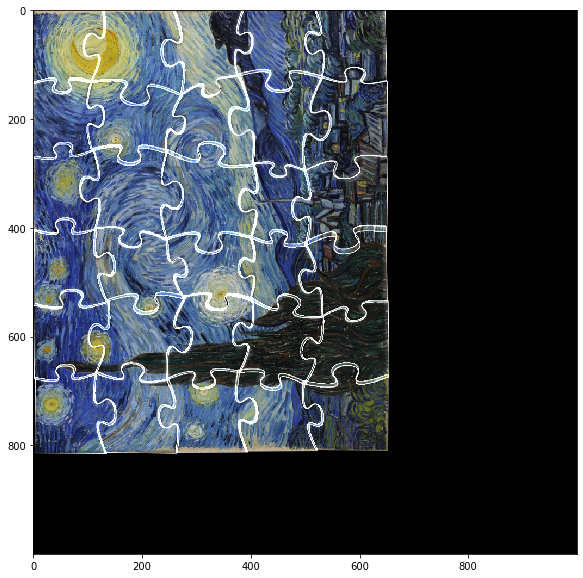

draw solution time 1.364924669265747


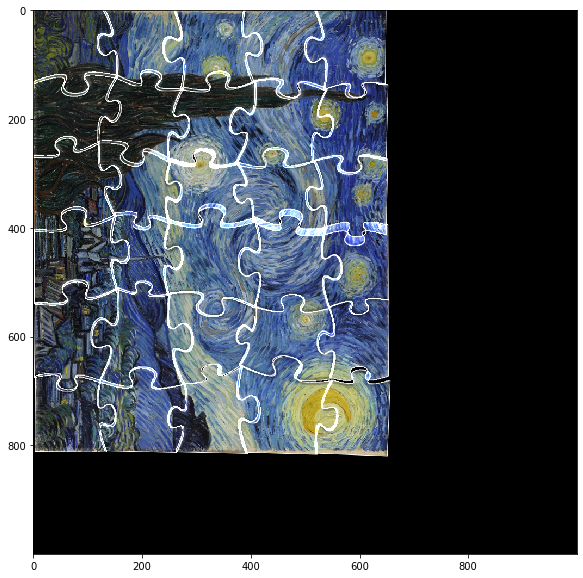

draw solution time 1.3490264415740967


In [436]:
ps = PuzzleSolver(puzzles)
res = ps.solve()

#ps.draw_solution(res)